# Hodgkin-Huxley Model

In [1]:
import numpy as np
import nolds
import scipy.io
import mne
import pandas as pd
import seaborn as sns
import pyqtgraph as pg
from scipy.io import loadmat
from scipy import stats
import matplotlib.pyplot as plt
import antropy as ent
from attractors import Attractor
from antropy import higuchi_fd
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.result import RQAResult
from pyrqa.opencl import OpenCL
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.image_generator import ImageGenerator
import numpy as np
import matplotlib.pyplot as plt
from antropy import higuchi_fd

In [2]:
# Load data
data = loadmat('/home/vincent/AAA_projects/MVCS/Neuroscience/downsampled/EEG_DS_Struct_0101.mat')

In [3]:
stim_data = pd.read_excel('/home/vincent/AAA_projects/MVCS/Neuroscience/EEG-tES-Chaos-Neural-Net/Stimulation.xlsx')
stim_data = stim_data.dropna()

stim_data = stim_data.rename(columns={"Unnamed: 13": "Stim Type Block 2",
                                      "Unnamed: 14": "Stim Type Block 3",
                                      "Unnamed: 16": "Stim Amplitude (mA) Block 2",
                                      "Unnamed: 17": "Stim Amplitude (mA) Block 3"})

In [4]:
DSamp = data['DSamp']

triggers = DSamp[0][0][0]
EEGdata = DSamp[0][0][1]
fs = DSamp[0][0][2][0][0] 
fsOld = DSamp[0][0][3][0][0] 
time = DSamp[0][0][4][0]
label = DSamp[0][0][5]
nchan = DSamp[0][0][6][0][0]
rate = DSamp[0][0][7][0][0]
npt = DSamp[0][0][8][0][0]
Subj = DSamp[0][0][9][0]
ptrackerPerf = DSamp[0][0][10]
ptrackerTime = DSamp[0][0][11]
ptrackerfs = DSamp[0][0][12][0][0]

In [5]:
print(DSamp, stim_data)

[[(array([[(array([[20.428]]), array([[20429]], dtype=uint16), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64)),
          (array([[619.442]]), array([[619443]], dtype=int32), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64)),
          (array([[619.499]]), array([[619500]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3')),
          (array([[654.746]]), array([[654747]], dtype=int32), array(['0032'], dtype='<U4'), array([[32]], dtype=uint8), array(['Stim Stop'], dtype='<U9'), array([], shape=(1, 0), dtype=float64)),
          (array([[770.515]]), array([[770516]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3')),
          (array([[805.571]])

In [4]:
import numpy as np
from scipy.integrate import odeint

# Constants for Hodgkin-Huxley model (in SI units)
Cm = 1.0 * 10**-6  # membrane capacitance, in Farads
g_Na = 120.0 * 10**-3  # maximum conducances, in Siemens
g_K = 36.0 * 10**-3
g_L = 0.3 * 10**-3
E_Na = 50.0  # Nernst reversal potentials, in mV
E_K = -77.0
E_L = -54.387
I = 10 * 10**-6  # constant input current in Ampere
V_min = -100  # Minimum potential, in mV
V_max = +50   # Maximum potential, in mV

# Hodgkin-Huxley equations
def alpha_m(V): return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))
def beta_m(V): return 4.0*np.exp(-(V+65.0) / 18.0)
def alpha_h(V): return 0.07*np.exp(-(V+65.0) / 20.0)
def beta_h(V): return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))
def alpha_n(V): return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))
def beta_n(V): return 0.125*np.exp(-(V+65) / 80.0)

def hodgkin_huxley(y, t):
    V, m, h, n = y
    dVdt = (I - g_Na*m**3*h*(V - E_Na) - g_K*n**4*(V - E_K) - g_L*(V - E_L)) / Cm
    dmdt = alpha_m(V)*(1.0-m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1.0-h) - beta_h(V)*h
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return [dVdt, dmdt, dhdt, dndt]

# Initialize a list to store the solutions for each channel
solutions = []

# Solve the ODE system for each channel
for chan in range(nchan):
    V_init = EEGdata[0][chan] / 1000  # if EEG data is in microvolts
    y0 = V_init, 0.05, 0.6, 0.32  # Updated Initial conditions
    print("Initial conditions for channel {}: V = {}, m = {}, h = {}, n = {}".format(chan, y0[0], y0[1], y0[2], y0[3]))

    t = np.linspace(0, len(EEGdata) / fs, len(EEGdata))  # Time points
    solution = odeint(hodgkin_huxley, y0, t)  # Solve ODE
    solution[:, 0] = np.clip(solution[:, 0], V_min, V_max)  # Clip V

    solutions.append(solution)

Initial conditions for channel 0: V = -21.295988649277845, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 1: V = -21.30374707675847, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 2: V = -21.315466571335175, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 3: V = -21.317809594099412, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 4: V = -21.325798141897327, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 5: V = -21.31565763410954, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 6: V = -21.315730727467088, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 7: V = -21.314808164778484, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 8: V = -21.319646413468288, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 9: V = -21.324010597029083, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 10: V = -21.310701657908034, m = 0.05, h = 0.6, n = 0.32
Initial conditions for channel 11: V = -21.3

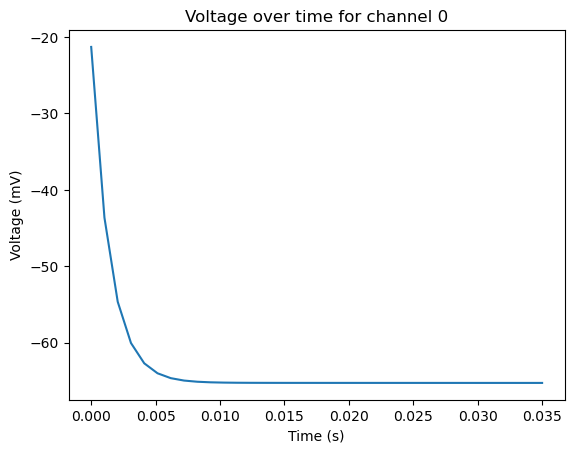

In [5]:
import matplotlib.pyplot as plt

# Get the solution for channel 0
solution = solutions[0]

# Time points
t = np.linspace(0, len(EEGdata) / fs, len(EEGdata))

# Plot the voltage over time
plt.plot(t, solution[:, 0])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage over time for channel 0')
plt.show()

In [6]:
V_init = EEGdata[0][chan] / 1000  # if EEG data is in microvolts


y0 = V_init, 0.05, 0.6, 0.32

In [7]:
print("Initial conditions for channel {}: V = {}, m = {}, h = {}, n = {}".format(chan, y0[0], y0[1], y0[2], y0[3]))

Initial conditions for channel 34: V = -21.28448465196033, m = 0.05, h = 0.6, n = 0.32
